In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import matplotlib.ticker as mticker

import seaborn
seaborn.set_context('talk')

from sqlalchemy import create_engine, text

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2025*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [2]:
import plotly
plotly.__version__


'5.22.0'

In [45]:
melb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')

airbnb_df = pandas.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv')

C:\Users\rbarone\AppData\Local\Temp\ipykernel_24120\590215205.py:4: DtypeWarning: Columns (35,77) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_df = pandas.read_csv(


## Ejercicio 1 SQL:

1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite

2. Ingestar los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.

3. Validar tipos de columnas antes de guardar: df.to_sql() infiere tipos automáticamente, pero a veces los nombres de columnas como Date, Price o ID dan problemas si vienen con strings o valores nulos.

4. Implementar consultas en SQL que respondan con la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.
    - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
    - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
    - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.

5. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.  



Creacion de Base de datos e ingesta

In [46]:
engine = create_engine("sqlite:///C:\\diplomatura\\to\\melbourne.db", echo=True)
# engine

melb_df.to_sql('melb', con=engine, if_exists='replace', index=False)

airbnb_df['zipcode'] = pandas.to_numeric( airbnb_df.zipcode, errors='coerce')
insertPriceAndZipcode = airbnb_df[['weekly_price','monthly_price', 'zipcode']].dropna()
insertPriceAndZipcode.to_sql('airbnb', con=engine, if_exists='replace', index=False)

airbnb_df.to_sql('airbnbAll', con=engine, if_exists='replace', index=False)
airbnb_df

2025-05-20 22:00:29,679 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 22:00:29,684 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-20 22:00:29,687 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 22:00:29,688 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("melb")
2025-05-20 22:00:29,689 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 22:00:29,690 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-20 22:00:29,691 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 22:00:29,692 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='view' AND name NOT LIKE 'sqlite~_%' ESCAPE '~' ORDER BY name
2025-05-20 22:00:29,693 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 22:00:29,695 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("melb")
2025-05-20 22:00:29,696 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 22:00:29,6

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,...,review_scores_location,review_scores_value,requires_license,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,9835,https://www.airbnb.com/rooms/9835,20181200000000.00,12/7/2018,Beautiful Room & House,NaN,"House: Clean, New, Modern, Quite, Safe. 10Km f...","House: Clean, New, Modern, Quite, Safe. 10Km f...",Very safe! Family oriented. Older age group.,NaN,...,9.00,9.00,f,NaN,f,strict_14_with_grace_period,f,f,1,0.04
1,10803,https://www.airbnb.com/rooms/10803,20181200000000.00,12/7/2018,Room in Cool Deco Apartment in Brunswick,A large air conditioned room with queen spring...,The apartment is Deco/Edwardian in style and h...,A large air conditioned room with queen spring...,This hip area is a crossroads between two grea...,NaN,...,9.00,9.00,f,NaN,t,moderate,t,t,1,1.50
2,12936,https://www.airbnb.com/rooms/12936,20181200000000.00,12/7/2018,St Kilda 1BR APT+BEACHSIDE+VIEWS+PARKING+WIFI+AC,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,FREE WiFi FREE in-building remote controlled g...,RIGHT IN THE HEART OF ST KILDA! It doesn't get...,A stay at our apartment means you can enjoy so...,First floor apartment with both lift and stair...,...,9.00,9.00,f,NaN,f,strict_14_with_grace_period,f,f,17,0.15
3,15246,https://www.airbnb.com/rooms/15246,20181200000000.00,12/7/2018,Large private room-close to city,"Comfortable, relaxed house, a home away from ...",The atmosphere is relaxed and easy going. You ...,"Comfortable, relaxed house, a home away from ...","This is a great neighbourhood – it is quiet, y...",A simple self service breakfast is available –...,...,9.00,9.00,f,NaN,f,moderate,f,f,3,0.30
4,16760,https://www.airbnb.com/rooms/16760,20181200000000.00,12/7/2018,Melbourne BnB near City & Sports,NaN,We offer comfortable accommodation in Inner Me...,We offer comfortable accommodation in Inner Me...,NaN,NaN,...,10.00,9.00,f,NaN,f,moderate,f,f,1,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22890,30592332,https://www.airbnb.com/rooms/30592332,20181200000000.00,12/7/2018,lovely home,"near city, near tram station",NaN,"near city, near tram station",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,1,NaN
22891,30592345,https://www.airbnb.com/rooms/30592345,20181200000000.00,12/7/2018,Melton South Getaway,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,"Close to: Melton Rail, Coles, Coffee Lounge an...",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,2,NaN
22892,30592362,https://www.airbnb.com/rooms/30592362,20181200000000.00,12/7/2018,"Glen Waverley(close to train, post, stores)近地铁...","Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",NaN,"Hi, 我是一名中国留学生. 由于暑假原因决定出租我的房间. 我会留下我所使用的物品给我的租...",NaN,NaN,...,NaN,NaN,f,NaN,t,flexible,f,f,1,NaN
22893,30592590,https://www.airbnb.com/rooms/30592590,20181200000000.00,12/7/2018,Crown Jewel in the heart of Melbourne,Immaculately presented and carefully maintaine...,Security is a focus with intercom-activated en...,Immaculately presented and carefully maintaine...,A plethora of Melbourne highlights are just a ...,NaN,...,NaN,NaN,f,NaN,t,moderate,f,f,17,NaN


In [5]:
query="select * from melb"

result = pandas.read_sql_query(query, engine)
result

2025-05-20 20:23:40,190 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,191 INFO sqlalchemy.engine.Engine select * from melb
2025-05-20 20:23:40,192 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,311 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,2.0,2.0,652.0,NaN,1981.0,None,-37.90562,145.16761,South-Eastern Metropolitan,7392.0
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,2.0,2.0,333.0,133.0,1995.0,None,-37.85927,144.87904,Western Metropolitan,6380.0
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,2.0,4.0,436.0,NaN,1997.0,None,-37.85274,144.88738,Western Metropolitan,6380.0
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,1.0,5.0,866.0,157.0,1920.0,None,-37.85908,144.89299,Western Metropolitan,6380.0


In [6]:
queryTotalRegistrosPorCiudad = "select count(*) as total, regionname from melb group by Regionname order by total desc;"
resultTotalRegistrosPorCiudad = pandas.read_sql(queryTotalRegistrosPorCiudad, con=engine)
resultTotalRegistrosPorCiudad


2025-05-20 20:23:40,368 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,369 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, regionname from melb group by Regionname order by total desc;")
2025-05-20 20:23:40,370 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,371 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, regionname from melb group by Regionname order by total desc;")
2025-05-20 20:23:40,371 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,372 INFO sqlalchemy.engine.Engine select count(*) as total, regionname from melb group by Regionname order by total desc;
2025-05-20 20:23:40,373 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,385 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Regionname
0,4695,Southern Metropolitan
1,3890,Northern Metropolitan
2,2948,Western Metropolitan
3,1471,Eastern Metropolitan
4,450,South-Eastern Metropolitan
5,53,Eastern Victoria
6,41,Northern Victoria
7,32,Western Victoria


In [7]:

queryTotalRegistrosPorBarrioYCiudad = "select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;"
resultTotalRegistrosPorBarrioYCiudad = pandas.read_sql(queryTotalRegistrosPorBarrioYCiudad, con=engine)
resultTotalRegistrosPorBarrioYCiudad

2025-05-20 20:23:40,402 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,403 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;")
2025-05-20 20:23:40,403 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,406 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;")
2025-05-20 20:23:40,406 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,407 INFO sqlalchemy.engine.Engine select count(*) as total, suburb from melb group by Regionname, suburb order by total desc;
2025-05-20 20:23:40,408 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,429 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Suburb
0,359,Reservoir
1,260,Richmond
2,249,Bentleigh East
3,239,Preston
4,222,Brunswick
...,...,...
309,1,Sandhurst
310,1,Plumpton
311,1,Rockbank
312,1,Bacchus Marsh


In [8]:
    # - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
    
queryTotalRegistrosPorCiudadConMasDe2Habitaciones = "select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;"
resultTotalRegistrosPorCiudadConMasDe2Habitaciones = pandas.read_sql(queryTotalRegistrosPorCiudadConMasDe2Habitaciones, con=engine)
resultTotalRegistrosPorCiudadConMasDe2Habitaciones


2025-05-20 20:23:40,464 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,466 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;")
2025-05-20 20:23:40,467 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,468 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;")
2025-05-20 20:23:40,470 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,472 INFO sqlalchemy.engine.Engine select count(*) as total, regionname from melb where rooms > 2 group by Regionname order by total desc;
2025-05-20 20:23:40,473 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,485 INFO sqlalchemy.engine.Engine ROLLBACK


,total,Regionname
0,2848,Southern Metropolitan
1,2389,Northern Metropolitan
2,2259,Western Metropolitan
3,1228,Eastern Metropolitan
4,407,South-Eastern Metropolitan
5,50,Eastern Victoria
6,39,Northern Victoria
7,31,Western Victoria


In [9]:
    # - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
queryPrecioPromedioPorTipoYCiudad = "select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;"
resultPrecioPromedioPorTipoYCiudad = pandas.read_sql(queryPrecioPromedioPorTipoYCiudad, con=engine)
resultPrecioPromedioPorTipoYCiudad

2025-05-20 20:23:40,506 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,508 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;")
2025-05-20 20:23:40,509 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,510 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;")
2025-05-20 20:23:40,511 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,513 INFO sqlalchemy.engine.Engine select round(avg(price) ,2) as precio_promedio, type, regionname from melb group by type, regionname order by precio_promedio desc;
2025-05-20 20:23:40,515 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,537 INFO sqlalchemy.engine.Engine ROLLBACK


,precio_promedio,Type,Regionname
0,1802241.08,h,Southern Metropolitan
1,1205404.47,t,Southern Metropolitan
2,1197450.46,h,Eastern Metropolitan
3,1021221.87,h,Northern Metropolitan
4,955949.62,h,South-Eastern Metropolitan
5,950766.27,h,Western Metropolitan
6,913270.00,t,South-Eastern Metropolitan
7,869619.92,t,Eastern Metropolitan
8,749608.31,t,Northern Metropolitan
9,720951.05,t,Western Metropolitan


In [10]:
    # - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.
queryTop5BarriosConPropiedadesMasCaras = "select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;"
resultTop5BarriosConPropiedadesMasCaras = pandas.read_sql(queryTop5BarriosConPropiedadesMasCaras, con=engine)
resultTop5BarriosConPropiedadesMasCaras


2025-05-20 20:23:40,563 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,564 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-20 20:23:40,565 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,567 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;")
2025-05-20 20:23:40,568 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,569 INFO sqlalchemy.engine.Engine select round(avg(price) ,2) as precio_promedio, suburb from melb group by suburb order by precio_promedio desc limit 5;
2025-05-20 20:23:40,571 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,586 INFO sqlalchemy.engine.Engine ROLLBACK


,precio_promedio,Suburb
0,2185000.00,Kooyong
1,2180240.74,Canterbury
2,2082529.41,Middle Park
3,1941355.07,Albert Park
4,1930158.00,Brighton


Ejercicio 5

In [11]:
queryJoin = "select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode"
resultJoin = pandas.read_sql(queryJoin, con=engine)
resultJoin

2025-05-20 20:23:40,605 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:23:40,606 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-20 20:23:40,608 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,609 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode")
2025-05-20 20:23:40,611 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:40,613 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode
2025-05-20 20:23:40,614 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:23:42,686 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,weekly_price,monthly_price
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
2,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
3,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
4,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,202.0,NaN,NaN,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,180.0,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188870,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,980.0,4001.0
188871,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,1070.0,3672.0
188872,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,1495.0,5550.0
188873,Yarraville,6 Agnes St,4,h,1285000.0,SP,Village,26/08/2017,6.3,3013.0,...,362.0,112.0,1920.0,None,-37.81188,144.88449,Western Metropolitan,6543.0,1700.0,3900.0


## Ejercicio 2 - Pandas:

1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.
  1. Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
  2.  Mostrar la dispersión o distribución de las columnas seleccionadas.
 3.  Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.
 4. Mostrar visualmente los valores extremos que eliminás



2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
  1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana (porque no la media?) o el mínimo.
  2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
  3. Mostrar un gráfico zipcode vs airbnb_price_median.
  4. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.
  5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.

¿Qué cosas no están en los datos que te gustaría tener para predecir mejor el precio de una propiedad?

In [24]:
#1 -Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.

#Vamos a utilizar la columnas Price, Rooms, Bedroom2 y bathroom ya que tienen una buena correlacion con el precio de las propiedades
queryEjercicio2 = "select * from melb"
resultCorrelacion = pandas.read_sql_query(queryEjercicio2, engine).select_dtypes(include=[numpy.number]).corr().abs()
resultCorrelacion['Price'].sort_values(ascending=False)


2025-05-20 21:31:42,682 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 21:31:42,683 INFO sqlalchemy.engine.Engine select * from melb
2025-05-20 21:31:42,684 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:31:42,809 INFO sqlalchemy.engine.Engine ROLLBACK


Price           1.00
Rooms           0.50
Bedroom2        0.48
Bathroom        0.47
YearBuilt       0.32
Car             0.24
Lattitude       0.21
Longtitude      0.20
Distance        0.16
Postcode        0.11
BuildingArea    0.09
Propertycount   0.04
Landsize        0.04
Name: Price, dtype: float64

In [18]:
melb_df.groupby('Regionname').agg(
    total=('Price', 'count'),
    precio_promedio=('Price', 'mean'),
    precio_median=('Price', 'median'),
    precio_max=('Price', 'max'),
    precio_min=('Price', 'min')
).reset_index().sort_values('total', ascending=False)

,Regionname,total,precio_promedio,precio_median,precio_max,precio_min
5,Southern Metropolitan,4695,1372963.37,1250000.00,8000000.00,131000.00
2,Northern Metropolitan,3890,898171.08,806250.00,4525000.00,145000.00
6,Western Metropolitan,2948,866420.52,793000.00,3900000.00,85000.00
0,Eastern Metropolitan,1471,1104079.63,1010000.00,4000000.00,288000.00
4,South-Eastern Metropolitan,450,922943.78,850000.00,9000000.00,266000.00
1,Eastern Victoria,53,699980.79,670000.00,1085000.00,400000.00
3,Northern Victoria,41,594829.27,540000.00,1355000.00,330000.00
7,Western Victoria,32,397523.44,400000.00,710000.00,280500.00


In [ ]:
# Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
quereSelectedColumns = "select Price, Rooms, Bedroom2, Bathroom  from melb"
rows = pandas.read_sql(quereSelectedColumns, con=engine)

totalValorFaltante = 0

for idx, fila in rows.iterrows():
    if fila.isnull().any():
        totalValorFaltante += 1
        continue

print(f"\nTotal de filas con al menos un valor faltante en su columna: {totalValorFaltante / len(rows) * 100:.2f}%")

rows.info()

2025-05-20 21:35:09,657 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 21:35:09,658 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select Price, Rooms, Bedroom2, Bathroom  from melb")
2025-05-20 21:35:09,660 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:35:09,661 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select Price, Rooms, Bedroom2, Bathroom  from melb")
2025-05-20 21:35:09,662 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:35:09,664 INFO sqlalchemy.engine.Engine select Price, Rooms, Bedroom2, Bathroom  from melb
2025-05-20 21:35:09,665 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:35:09,706 INFO sqlalchemy.engine.Engine ROLLBACK

Total de filas con al menos un valor faltante en su columna: 0.00%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     13580 non-null  float64
 1   

In [38]:
columnasSeleccionadas = ['Price', 'Rooms', 'Bedroom2', 'Bathroom']
result = pandas.read_sql(queryEjercicio2, con=engine)[columnasSeleccionadas]

result.sort_values(by='Price', ascending=True)


2025-05-20 21:49:42,246 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 21:49:42,247 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select * from melb")
2025-05-20 21:49:42,248 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:49:42,251 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select * from melb")
2025-05-20 21:49:42,252 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:49:42,253 INFO sqlalchemy.engine.Engine select * from melb
2025-05-20 21:49:42,253 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 21:49:42,544 INFO sqlalchemy.engine.Engine ROLLBACK


,Price,Rooms,Bedroom2,Bathroom
2652,85000.00,1,1.00,1.00
1805,131000.00,4,4.00,1.00
7303,145000.00,1,2.00,1.00
1927,145000.00,4,3.00,1.00
7940,160000.00,1,1.00,1.00
...,...,...,...,...
12557,6400000.00,5,5.00,2.00
3616,6500000.00,6,6.00,6.00
9575,7650000.00,4,4.00,2.00
7692,8000000.00,5,5.00,5.00


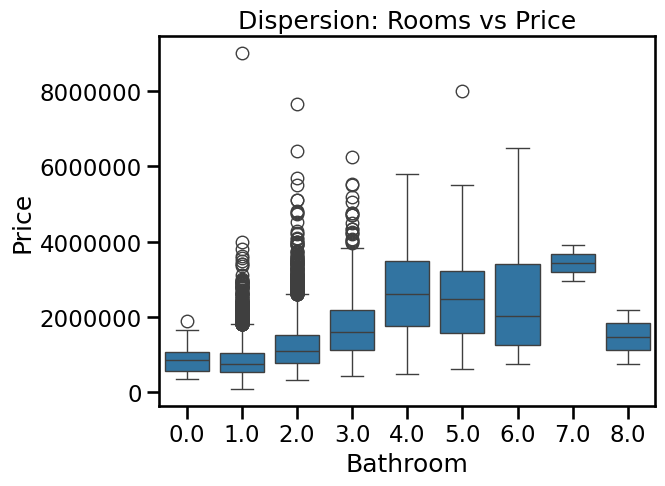

In [40]:
# 2.  Mostrar la dispersión o distribución de las columnas seleccionadas.

ax = seaborn.boxplot(x='Bathroom', y='Price', data=result)
plt.title('Dispersion: Rooms vs Price')

ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

plt.show()

2025-05-20 20:24:04,533 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 20:24:04,535 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1801000.0")
2025-05-20 20:24:04,536 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:24:04,536 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1801000.0")
2025-05-20 20:24:04,538 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:24:04,539 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1801000.0
2025-05-20 20:24:04,540 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 20:24:06,317 INFO sqlalchemy.engine.Engine ROLLBACK


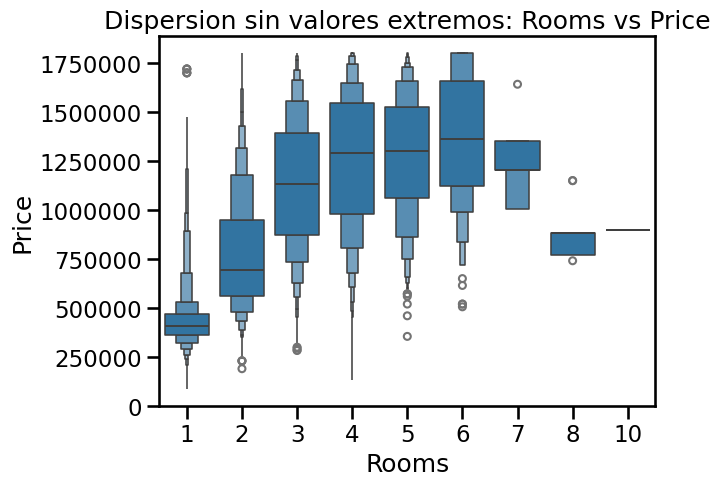

In [17]:
#Eliminar valores atípicos de propiedades con valores mayor a 6 millone

pandas.set_option('display.float_format', lambda x: '%.2f' % x)
quantile=  resultJoin['Price'].quantile(0.90)


queryJoin = "select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < "+ str(quantile)    

resultJoin = pandas.read_sql(queryJoin, con=engine)

ax = seaborn.boxenplot(x='Rooms', y='Price', data=resultJoin)
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))

plt.title('Dispersion sin valores extremos: Rooms vs Price')
plt.show()

In [48]:
# Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
#   1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana (porque no la media?) o el mínimo.
#   2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
#   3. Mostrar un gráfico zipcode vs airbnb_price_median.
#   4. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.
#   5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?

resultAirbnb = pandas.read_sql(queryJoin, con=engine)
resultAirbnb


2025-05-20 22:09:53,712 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-20 22:09:53,713 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1801000.0")
2025-05-20 22:09:53,714 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 22:09:53,716 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1801000.0")
2025-05-20 22:09:53,718 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 22:09:53,719 INFO sqlalchemy.engine.Engine select m.*, a.weekly_price, a.monthly_price from melb m left join airbnb a on m.postcode = a.zipcode where price < 1801000.0
2025-05-20 22:09:53,721 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-20 22:09:55,672 INFO sqlalchemy.engine.Engine ROLLBACK


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,weekly_price,monthly_price
0,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,...,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,180.00,700.00
1,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,...,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,180.00,700.00
2,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,...,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,180.00,700.00
3,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,...,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,180.00,700.00
4,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,...,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00,180.00,700.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169978,Yarraville,6 Agnes St,4,h,1285000.00,SP,Village,26/08/2017,6.30,3013.00,...,362.00,112.00,1920.00,None,-37.81,144.88,Western Metropolitan,6543.00,980.00,4001.00
169979,Yarraville,6 Agnes St,4,h,1285000.00,SP,Village,26/08/2017,6.30,3013.00,...,362.00,112.00,1920.00,None,-37.81,144.88,Western Metropolitan,6543.00,1070.00,3672.00
169980,Yarraville,6 Agnes St,4,h,1285000.00,SP,Village,26/08/2017,6.30,3013.00,...,362.00,112.00,1920.00,None,-37.81,144.88,Western Metropolitan,6543.00,1495.00,5550.00
169981,Yarraville,6 Agnes St,4,h,1285000.00,SP,Village,26/08/2017,6.30,3013.00,...,362.00,112.00,1920.00,None,-37.81,144.88,Western Metropolitan,6543.00,1700.00,3900.00


In [ ]:
airbnb_df.groupby('zipcode').agg(
    total=('Price', 'count'),
    precio_promedio=('Price', 'mean'),
    precio_median=('Price', 'median')
).reset_index().sort_values('total', ascending=False)

## Ejercicio 3:

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

## Ejercicios opcionales:

1. Armar un script en python (archivo .py) [ETL](https://towardsdatascience.com/what-to-log-from-python-etl-pipelines-9e0cfe29950e) que corra los pasos de extraccion, transformacion y carga, armando una funcion para cada etapa del proceso y luego un main que corra todos los pasos requeridos.

2. Armar un DAG en Apache Airflow que corra el ETL. (https://airflow.apache.org/docs/apache-airflow/stable/tutorial.html)